NUOVA

In [38]:
# Import the necessary functions
import logging
# Set the logging level to WARNING to suppress INFO messages
logging.basicConfig(level=logging.WARNING)
import transformers

#logging.set_verbosity_error()
# Disable specific warnings
transformers.logging.set_verbosity_error()
from inference_utils import load_model_and_tokenizer, generate_predictions, setup_device
import json #, jsonlines

from transformers import GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
import torch

from tqdm import tqdm

In [2]:
# Define the model path
MODEL_PATH ="/dtu-compute/s220331/composition/outputs_BIG_new/checkpoint-1500000/"
# "/scratch/davide/model_paper/outputs_SMALL_sharing/checkpoint-1500000/" #"/scratch/davide/model_paper/outputs_OOD_MODIFIED_composition_SMALL.200.20.18.0/checkpoint-350000/"

# Load the model and tokenizer
model_1, tokenizer_1 = load_model_and_tokenizer(MODEL_PATH)

# Setup the device
device = setup_device()
model_1.to(device)

# Prepare the input data for prediction
input_texts = ["<e_0><r_14><r_6>"]

# Define the parameters for generation
max_length = 10  # Adjust the max_length as needed
num_return_sequences = 1  # Adjust the number of return sequences

# Generate predictions
#predictions = generate_predictions(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)
def predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences):
    predictions = generate_predictions(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)
    # Print the predictions
    for i, prediction in enumerate(predictions):
        print(f"Input: {input_texts[i]}")
        print(f"Prediction: {prediction}")

In [39]:
# To chose the "B" that compare 2 times both in ID and OOD**
def chose_B(range_):
    count=0
    for i in range(range_):
        target = f'<e_{i}></a>'
        t_print=f'<e_{i}>'
        filtered_texts = [entry['target_text'] for entry in d['id_atomic'] if entry['target_text'].endswith(target)]

        filtered_texts_OOD = [entry['target_text'] for entry in d['ood_atomic'] if entry['target_text'].endswith(target)]
        if count <=3:
            if len(filtered_texts) >= 2 and len(filtered_texts_OOD) >= 2:

                filtered_texts_2_hop = [entry['target_text'] for entry in d['id_atomic'] if entry['target_text'].startswith(t_print)]

                filtered_texts_OOD_2_hop = [entry['target_text'] for entry in d['ood_atomic'] if entry['target_text'].startswith(t_print)]

                # Extract the part before <e_57></a> from the first element
                #atomic_part_1_id = filtered_texts[0].split(target)[0]
                #print("atomic_id", atomic_part_1_id)
                #atomic_part_1_ood = str(filtered_texts_OOD[0].split(target)[0])

                #inferred_OOD = [entry['target_text'] for entry in d['test_inferred_ood']
                #                    if entry['type'] == 'test_inferred_ood' and entry['input_text'].startswith(atomic_part_1_ood)]

                #inferred_ID = [entry['target_text'] for entry in d['test_inferred_iid']
                #                    if entry['type'] == 'test_inferred_iid' and entry['input_text'].startswith(atomic_part_1_id)]

                if len(filtered_texts_2_hop) >= 1 and len(filtered_texts_OOD_2_hop) >= 1:
                    print("-------Target :", t_print,  "     ----------------------------------------------------------\n")
                    print("ID",filtered_texts   ,"\n")
                    print("OOD",filtered_texts_OOD   ,"\n \n")

                    #print("Inferred _ ID", inferred_ID)
                    #print("Inferred _ OOD", inferred_OOD)
                    # for the second hop

                    count+=1
                    print("2- hop  ID", filtered_texts_2_hop)
                    print("2nd hop OOD", filtered_texts_OOD_2_hop, "\n \n \n")


In [40]:
def return_rank(hd, word_embedding_, token, metric='dot', token_list=None):
    """
hd: Hidden states or output from a neural network.
word_embedding_: Embedding matrix for words. (matrix that convert words to their embedding representation)
token: The specific token (word) for which we want to find the rank.
metric: The similarity metric to use ('dot' for dot product, 'cos' for cosine similarity).
token_list: Optional list of tokens to consider for ranking."""

    if metric == 'dot':
        word_embedding = word_embedding_
    elif metric == 'cos':
        word_embedding = F.normalize(word_embedding_, p=2, dim=1)
    else:
        assert False
    #Compute the similarity scores (logits) between the hidden states (hd) and the word embeddings using matrix multiplication.
    logits_ = torch.matmul(hd, word_embedding.T)  # a vlaue higher if he similarity with the analyzed "word" is higehr

    rank = [] 
    for j in range(len(logits_)):
        log = logits_[j].cpu().numpy()
        if token_list is None:
            temp = [[i, log[i]] for i in range(len(log))]
        else:
            temp = [[i, log[i]] for i in token_list]
        temp.sort(key=lambda var: var[1], reverse=True)
        rank.append([var[0] for var in temp].index(token))
    return rank


#  "Normal case " 
<e_172>  comes from two different inputs eg:
> <e_12><r_5>            -->   <e_172>
 
> <e_1><r_3>            -->   <e_172>


1) Compute the Difference Vector: 
**\text{vector\_sub}** = \text{<e_172>}_{first case}} - \text{<e_172>}_{second case}}

2) Subtract the Difference Vector: \text{cleaned\_vector} = \text{<e_172>} - **\text{vector\_sub}**

In [57]:
#dataset = "/home/s220331/GROK/Thesis/data/composition_SMALL.200.20.12.6"
dataset="/home/s220331/GROK/Thesis/data/composition.2000.200.12.6"
model_path = "/scratch/davide/model_paper/outputs_SMALL/checkpoint-1500000/" # model normal on small dataset wuth chosen checkpoints!

target_layer = 8

In [58]:


# set data

all_atomic = set()     # (h,r,t)
atomic_dict = dict()   # (h,r) -> t
with open(dataset+"/train.json") as f:  # from the correct data or data_MIO !!!
    train_items = json.load(f)
for item in tqdm(train_items):
    temp = item['target_text'].strip("><").split("><")
    if len(temp) != 4:
        continue
    h,r,t = temp[:3]
    atomic_dict[(h,r)] = t
    all_atomic.add((h,r,t))

id_atomic = set()
for item in tqdm(train_items):
    temp = item['target_text'].strip("><").split("><")
    if len(temp) == 4:
        continue
    h, r1, r2, t = temp[:4]
    b = atomic_dict[(h, r1)]
    assert atomic_dict[(b, r2)] == t
    id_atomic.add((h,r1,b))
    id_atomic.add((b,r2,t))

ood_atomic = all_atomic - id_atomic
print("# id_atomic, # ood_atomic:", len(id_atomic), len(ood_atomic))

# smart way to save all the train
with open(dataset+"/test.json") as f:
    pred_data = json.load(f)
d = dict()
for item in pred_data:
    t = item['type']
    if t not in d:
        d[t] = []
    d[t].append(item)

100%|██████████| 518800/518800 [00:01<00:00, 420077.11it/s]


# id_atomic, # ood_atomic: 38000 2000


In [7]:
# model set up
#device = torch.device('cuda:5')
device = setup_device()
model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
word_embedding = model.lm_head.weight.data
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
tokenizer.padding_side = "left" 
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
model.config.pad_token_id = model.config.eos_token_id

**To chose the "B" that compare 2 times both in ID and OOD**

In [59]:
chose_B(199)


-------Target : <e_18>      ----------------------------------------------------------

ID ['<e_1826><r_67><e_18></a>', '<e_467><r_133><e_18></a>'] 

OOD ['<e_1380><r_34><e_18></a>', '<e_749><r_76><e_18></a>'] 
 

2- hop  ID ['<e_18><r_158><e_674></a>', '<e_18><r_166><e_1282></a>', '<e_18><r_165><e_883></a>', '<e_18><r_162><e_335></a>']
2nd hop OOD ['<e_18><r_131><e_481></a>', '<e_18><r_119><e_1389></a>'] 
 
 

-------Target : <e_25>      ----------------------------------------------------------

ID ['<e_1192><r_127><e_25></a>', '<e_1858><r_169><e_25></a>', '<e_589><r_20><e_25></a>'] 

OOD ['<e_278><r_109><e_25></a>', '<e_1588><r_196><e_25></a>'] 
 

2- hop  ID ['<e_25><r_161><e_323></a>', '<e_25><r_196><e_179></a>']
2nd hop OOD ['<e_25><r_163><e_958></a>'] 
 
 

-------Target : <e_68>      ----------------------------------------------------------

ID ['<e_1405><r_128><e_68></a>', '<e_1314><r_160><e_68></a>'] 

OOD ['<e_1342><r_181><e_68></a>', '<e_915><r_91><e_68></a>'] 
 

2- hop  

In [9]:
# we can set   h, r_1 , r_2 manually here  (and get also the b  and t entities connected)
#------Target : <e_11>      ----------------------------------------------------------

#ID ['<e_150><r_11><e_11></a>', '<e_140><r_19><e_11></a>', '<e_128><r_3><e_11></a>'] 

#OOD ['<e_147><r_4><e_11></a>', '<e_9><r_16><e_11></a>'] 

#2nd hop id ['<e_11><r_11><e_88></a>']
#2 nd hop  OOD ['<e_11><r_1><e_141></a>']   

query = "<e_140><r_19><r_11>"      # the inferred chosen (by combining the ID and 2nd hop)
h,n_r,r = query.strip("><").split("><") #"e_140","r_19","r_11"             #query.strip("><").split("><")
b = atomic_dict[(h, n_r)]
t = atomic_dict[(b, r)]

print("b:",b)
print("tail:",t)

b: e_11
tail: e_88



**Now we tokenize the query** and extract:
>id of the tokenized query 
and

> attention mask

In [10]:
# Tokenizing the Query:
decoder_temp = tokenizer([query], return_tensors="pt", padding=True)
decoder_input_ids, decoder_attention_mask = decoder_temp["input_ids"], decoder_temp["attention_mask"]
decoder_input_ids, decoder_attention_mask = decoder_input_ids.to(device), decoder_attention_mask.to(device)

**Model Inference**

Here, the model processes the tokenized input without computing gradients (torch.no_grad()), which is useful for inference to save memory and computation. The model outputs include hidden states from all layers because output_hidden_states=True.

In [11]:
with torch.no_grad():
    outputs = model(
        input_ids=decoder_input_ids,
        attention_mask=decoder_attention_mask,
        output_hidden_states=True
    )
all_hidden_states = outputs['hidden_states']

Alpha scaling not found in config. Defaulting to alpha = 1.0


Ranking Calculation
In the dictionary **rest_di**c with the key (="rank_before"), is stored the **rank** of the given **t**t (tail).

 This means basically that by projecting the hidden state at the chosen layer, the **t** is in the n position (rank).

> eg:  0= Is the most probable (=chosen) output token  (rank in first position)


The **[-2]** indicates that we are taking in consideration the 2ns last input tokwn (e,**r_1**,r_2)

We use -1 normally to  inspectionate the tail, -2 for the **b** bridge entity

return_rank(all_hidden_states[target_layer][0, :, :], word_embedding, tokenizer("<"+b+">")['input_ids'][0])**[-2]**


In [12]:
target_layer_tail = 8
res_dict_tail = dict()
#<r_11>

rank_before = return_rank(all_hidden_states[target_layer_tail][0, :, :], word_embedding, tokenizer("<"+t+">")['input_ids'][0])[-1]
res_dict_tail['rank_before'] = rank_before
res_dict_tail

{'rank_before': 0}

In [13]:
res_dict_b = dict()
target_layer_b = 5
# ("<"+ b +">")  is just for reconstructing ("<b>") from "b"
rank_before = return_rank(all_hidden_states[target_layer_b][0, :, :], word_embedding, tokenizer("<"+ b +">")['input_ids'][0])[-2]
res_dict_b['rank_before'] = rank_before
print("Rabk B should be 0:",res_dict_b)

Rabk B should be 0: {'rank_before': 0}


Now we want to use the same model but insert a different input (a,r,b)  instead of (a*,r*,b).

The idea is to see if the b found in 4th state in this case, if inserted in the 4th, state of the normal run, if it will change the prediction.

In [14]:
query_change_id = "<e_128><r_6><r_11>"#this is changed with different "B" and "t"    # 2 hop <e_11><r_11><e_88>
# era "<e_128><r_3><r_11>" oggi
# this only is oood <e_147><r_4>


h_1_id,n_r_1_id,r_1_id = query_change_id.strip("><").split("><") #"e_140","r_19","r_11"             #query.strip("><").split("><")
b_1_id = atomic_dict[(h_1_id ,n_r_1_id)]
t_1_id = atomic_dict[(b_1_id, r_1_id)]
print("b:",b_1_id)
print("tail:",t_1_id)


# Tokenizing the Query:
decoder_temp_1_id = tokenizer([query_change_id], return_tensors="pt", padding=True)
decoder_input_ids_1_id, decoder_attention_mask_1_id = decoder_temp_1_id["input_ids"], decoder_temp_1_id["attention_mask"]
decoder_input_ids_1_id, decoder_attention_mask_1_id = decoder_input_ids_1_id.to(device), decoder_attention_mask_1_id.to(device)


with torch.no_grad():
    # here the same model but with different input !! 
    outputs_1_id = model(
        input_ids=decoder_input_ids_1_id,
        attention_mask=decoder_attention_mask_1_id,
        output_hidden_states=True
    )
# hidden state of the 1_id (which will be inserted in the normal run)
all_hidden_states_1_id = outputs_1_id['hidden_states']

#################### just to quick check everything is right

res_dict_b_1_id = dict()
target_layer_b = 4
# ("<"+ b +">")  is just for reconstructing ("<b>") from "b"
rank_before_1_id = return_rank(all_hidden_states_1_id[target_layer_b][0, :, :], word_embedding, tokenizer("<"+ b +">")['input_ids'][0])[-2]
res_dict_b_1_id['rank_before'] = rank_before_1_id
print(" B 1_id",res_dict_b_1_id)



b: e_32
tail: e_135
Alpha scaling not found in config. Defaulting to alpha = 1.0
 B 1_id {'rank_before': 147}


In [15]:
# <e_128><r_3><r_11> b= e_11
target_layer_intervention = 5
target_layer_final = 8
# juest rename for more standardized structure
all_hidden_states_ctft = all_hidden_states_1_id

# we are analysing  with replacing only specific hidden state once a time
for layer_to_intervene in range(target_layer_intervention , target_layer_intervention+1 ):
    print(layer_to_intervene)
    hidden_states = all_hidden_states[layer_to_intervene].clone()    # cloniamo gli hidden del normal run
    hidden_states_ctft = all_hidden_states_ctft[layer_to_intervene]  # copiamo quelli del run che inseriremo
    # intervene
    hidden_states[0, 0, :] = hidden_states_ctft[0, 0, :]   #insereiamo gli hidden state che vogliamo
    hidden_states[0, 1, :] = hidden_states_ctft[0, 1, :]   #insereiamo gli hidden state che vogliamo
    hidden_states[0, 2, :] = hidden_states_ctft[0, 2, :]   #insereiamo gli hidden state che vogliamo
    r_11_id = hidden_states_ctft[0, 2, :]

    rank_middle = return_rank(hidden_states[0, :, :], word_embedding, tokenizer("<"+b+">")['input_ids'][0])[-2]
    res_dict_b["insertion at layer"+str(layer_to_intervene), "B"] = rank_middle
    #                
    with torch.no_grad():
        for i in range(layer_to_intervene, target_layer_final):
            f_layer = model.transformer.h[i]  # current layer

            # attention mechanism 
            residual = hidden_states       #store the hidden state in residual
            # Apply layer normalization to hidden_states.
            hidden_states = f_layer.ln_1(hidden_states)
            attn_output = f_layer.attn(hidden_states)[0] 
            hidden_states = attn_output + residual
            # mlp  = Feed-Forward Network:
            residual = hidden_states
            hidden_states = f_layer.ln_2(hidden_states)
            feed_forward_hidden_states = f_layer.mlp.c_proj(f_layer.mlp.act(f_layer.mlp.c_fc(hidden_states)))
            hidden_states = residual + feed_forward_hidden_states
        # final ln
        hidden_states = model.transformer.ln_f(hidden_states)
    # print("--------")
    rank_after = return_rank(hidden_states[0, :, :], word_embedding, tokenizer("<"+t+">")['input_ids'][0])[-1]  #t_1_id
    res_dict_b["Out-tput layer"+str(target_layer_final), "t"] = rank_after

print( res_dict_b)


5
{'rank_before': 0, ('insertion at layer5', 'B'): 124, ('Out-tput layer8', 't'): 156}


## PURE B section

In [16]:
# This query has in its 3rd place the B already!

query_PURE ="<e_150><r_11><e_11>" #"<e_128><r_3><e_11>"    # 2 hop <e_11><r_11><e_88>

h_1_PURE,n_r_1_PURE,r_1_PURE = query_PURE.strip("><").split("><") #"e_140","r_19","r_11"   

r_1_PURE="r_11"          #query.strip("><").split("><")
b_1_PURE = atomic_dict[(h_1_PURE ,n_r_1_PURE)]
t_1_PURE = atomic_dict[(b_1_PURE, r_1_PURE)]
print("b PURE:",b_1_PURE)
print("tail:",t_1_PURE)


# Tokenizing the Query:
decoder_temp_1_PURE = tokenizer([query_PURE], return_tensors="pt", padding=True)
decoder_input_ids_1_PURE, decoder_attention_mask_1_PURE = decoder_temp_1_PURE["input_ids"], decoder_temp_1_PURE["attention_mask"]
decoder_input_ids_1_PURE, decoder_attention_mask_1_PURE = decoder_input_ids_1_PURE.to(device), decoder_attention_mask_1_PURE.to(device)


with torch.no_grad():
    # here the same model but with different input !! 
    outputs_1_PURE = model(
        input_ids=decoder_input_ids_1_PURE,
        attention_mask=decoder_attention_mask_1_PURE,
        output_hidden_states=True
    )
# hidden state of the 1_id (which will be inserted in the normal run)
all_hidden_states_1_PURE = outputs_1_PURE['hidden_states']

#################### just to quick check everything is right

res_dict_b_1_PURE = dict()
target_layer_b = 4
# ("<"+ b +">")  is just for reconstructing ("<b>") from "b"
rank_before_1_PURE = return_rank(all_hidden_states_1_PURE[target_layer_b][0, :, :], word_embedding, tokenizer("<"+ b_1_PURE +">")['input_ids'][0])[-2]
res_dict_b_1_PURE['rank_before'] = rank_before_1_PURE

rank_after_1 = return_rank(all_hidden_states_1_PURE[target_layer_tail][0, :, :], word_embedding, tokenizer("<"+t_1_PURE+">")['input_ids'][0])[-1]
res_dict_b_1_PURE["Out-tput layer"+str(target_layer_final), "t"] = rank_after_1
print(" B PURE",res_dict_b_1_PURE)
print(" Here we check that we actually find the B at layer 5. It means that we have = rank 0 right above")
print(" The T should not be 0!!!!!!  \n as the do not put a r_2 but the B in 3rd place!!")



b PURE: e_11
tail: e_88
Alpha scaling not found in config. Defaulting to alpha = 1.0
 B PURE {'rank_before': 0, ('Out-tput layer8', 't'): 95}
 Here we check that we actually find the B at layer 5. It means that we have = rank 0 right above
 The T should not be 0!!!!!!  
 as the do not put a r_2 but the B in 3rd place!!


In [17]:
# This query should have already B
query_PURE_R_2 = "<e_1><r_11><r_11>"  # "<e_128><r_3><e_11>"    # 2 hop <e_11><r_11><e_88>

# This only is good <e_147><r_4>

h_1_PURE_R_2, n_r_1_PURE_R_2, r_1_PURE_R_2 = query_PURE_R_2.strip("><").split("><")  # "e_140","r_19","r_11"

#r_1_PURE_R_2 =  query.strip("><").split("><") #"r_11"  #
b_1_PURE_R_2 = atomic_dict[(h_1_PURE_R_2, n_r_1_PURE_R_2)]
t_1_PURE_R_2 = atomic_dict[(b_1_PURE_R_2, r_1_PURE_R_2)]
print("b PURE_R_2:", b_1_PURE_R_2)
print("tail:", t_1_PURE_R_2)

# Tokenizing the Query:
decoder_temp_1_PURE_R_2 = tokenizer([query_PURE_R_2], return_tensors="pt", padding=True)
decoder_input_ids_1_PURE_R_2, decoder_attention_mask_1_PURE_R_2 = decoder_temp_1_PURE_R_2["input_ids"], decoder_temp_1_PURE_R_2["attention_mask"]
decoder_input_ids_1_PURE_R_2, decoder_attention_mask_1_PURE_R_2 = decoder_input_ids_1_PURE_R_2.to(device), decoder_attention_mask_1_PURE_R_2.to(device)

with torch.no_grad():
    # Here the same model but with different input !!
    outputs_1_PURE_R_2 = model(
        input_ids=decoder_input_ids_1_PURE_R_2,
        attention_mask=decoder_attention_mask_1_PURE_R_2,
        output_hidden_states=True
    )
# Hidden state of the 1_id (which will be inserted in the normal run)
all_hidden_states_1_PURE_R_2 = outputs_1_PURE_R_2['hidden_states']

#################### Just to quickly check everything is right

res_dict_b_1_PURE_R_2 = dict()
target_layer_b = 4
# ("<"+ b +">") is just for reconstructing ("<b>") from "b"
rank_before_1_PURE_R_2 = return_rank(all_hidden_states_1_PURE_R_2[target_layer_b][0, :, :], word_embedding, tokenizer("<" + b_1_PURE_R_2 + ">")['input_ids'][0])[-2]
res_dict_b_1_PURE_R_2['rank_before'] = rank_before_1_PURE_R_2

rank_after_2 = return_rank(all_hidden_states_1_PURE_R_2[target_layer_tail][0, :, :], word_embedding, tokenizer("<"+t_1_PURE_R_2+">")['input_ids'][0])[-1]
res_dict_b_1_PURE_R_2["Out-put layer_"+str(target_layer_final), "t"] = rank_after_2
print("B PURE_R_2", res_dict_b_1_PURE_R_2)
print("Here we check that we actually find the B at layer 5 = rank 0")

b PURE_R_2: e_99
tail: e_51
Alpha scaling not found in config. Defaulting to alpha = 1.0
B PURE_R_2 {'rank_before': 0, ('Out-put layer_8', 't'): 0}
Here we check that we actually find the B at layer 5 = rank 0


## PURE B INTERVENTION

In [18]:
b


'e_11'

In [19]:
# <e_128><r_3><r_11> b= e_11
target_layer_intervention = 5
target_layer_final = 8
# juest rename for more standardized structure
all_hidden_states_ctft = all_hidden_states_1_PURE  # the one with B instead of r_2

# we are analysing  with replacing only specific hidden state once a time
for layer_to_intervene in range(target_layer_intervention , target_layer_intervention+1 ):
    print(layer_to_intervene)
    hidden_states = all_hidden_states[layer_to_intervene].clone()    # cloniamo gli hidden del normal run
    hidden_states_R_TEST = all_hidden_states[0].clone()    # cloniamo gli hidden del normal run
    hidden_states_R_TEST_layer_0_1_position= all_hidden_states_1_PURE_R_2[4].clone()   # layer 0
    # intervene normal
    hidden_states_ctft = all_hidden_states_ctft[0]  # copiamo quelli del run che inseriremo
    #hidden_states[0, 0, :] = hidden_states_ctft[0, 0, :]   #insereiamo gli hidden state che vogliamo
    #hidden_states[0, 1, :] = hidden_states_ctft[0, 2, :]   #insereiamo gli hidden state che vogliamo
    #hidden_states[0, 2, :] = hidden_states_ctft[0, 2, :]   #insereiamo gli hidden state che vogliamo
    #hidden_states[0, 2, :] =        r_11_id   # "r_2" =<r_11> layer 4 ID

    #intevento PURE B
    #hidden_states_ctft = all_hidden_states_ctft[0]  # copiamo quelli del run che inseriremo
    #hidden_states[0, 0, :] = hidden_states_ctft[0, 0, :]   #insereiamo gli hidden state che vogliamo
    #hidden_states[0, 1, :] = hidden_states_ctft[0, 2, :]   #insereiamo gli hidden state che vogliamo
    # Tokenize the word "r"  <r_11>
    #tokenized_r_2 = tokenizer("r_11")['input_ids'][0]
    #hidden_states[0, 2, :] = model.transformer.wte(torch.tensor(tokenized_r_2)).squeeze()
    #hidden_states[0, 2, :] = hidden_states_R_TEST[0, 2, :]   # Hidden state di R_2 (normal run)  ma layer 0 fallisce
    hidden_states[0, 2, :]= hidden_states_R_TEST_layer_0_1_position[0, 2, :]

    rank_middle = return_rank(hidden_states[0, :, :], word_embedding, tokenizer("<"+b+">")['input_ids'][0])[-2]
    res_dict_b["insertion at layer"+str(layer_to_intervene), "B"] = rank_middle
    #                
    with torch.no_grad():
        for i in range(layer_to_intervene, target_layer_final):
            f_layer = model.transformer.h[i]  # current layer

            # attention mechanism 
            residual = hidden_states       #store the hidden state in residual
            # Apply layer normalization to hidden_states.
            hidden_states = f_layer.ln_1(hidden_states)
            attn_output = f_layer.attn(hidden_states)[0] 
            hidden_states = attn_output + residual
            # mlp  = Feed-Forward Network:
            residual = hidden_states
            hidden_states = f_layer.ln_2(hidden_states)
            feed_forward_hidden_states = f_layer.mlp.c_proj(f_layer.mlp.act(f_layer.mlp.c_fc(hidden_states)))
            hidden_states = residual + feed_forward_hidden_states
        # final ln
        hidden_states = model.transformer.ln_f(hidden_states)
    # print("--------")
    rank_after = return_rank(hidden_states[0, :, :], word_embedding, tokenizer("<"+t+">")['input_ids'][0])[-1]
    res_dict_b["Out-tput layer"+str(target_layer_final), "t"] = rank_after

print( res_dict_b)


5
{'rank_before': 0, ('insertion at layer5', 'B'): 0, ('Out-tput layer8', 't'): 0}


Interessante vedere che azzecca B e T se metto pure "B" (B di layer_0 a layer 5).

 Ma se metto anche r_2 di layer 0 invece non azzecca piu!

In [20]:
res_dict_b= dict()

## OOD case
 > #OOD ['<e_147><r_4><e_11></a>', '<e_9><r_16><e_11></a>'] 
 
>2 nd hop  OOD ['<e_11><r_1><e_141></a>'] 

------Target : <e_114>      ----------------------------------------------------------

ID ['<e_181><r_6><e_114></a>', '<e_84><r_13><e_114></a>'] 

OOD ['<e_123><r_8><e_114></a>', '<e_14><r_12><e_114></a>'] 
 

2- hop  ID ['<e_114><r_5><e_137></a>']
2nd hop OOD ['<e_114><r_13><e_117></a>'] 

gia composto id : "<e_181><r_6><r_5>"

In [21]:
query_change_OOD ="<e_147><r_4><r_1>" #"<e_181><r_6><r_5>"# "<e_147><r_4><r_1>"# "<e_14><r_12><r_13>"       # 2 hop ['<e_11><r_1><e_141></a>'] 
# usato "<e_147><r_4><r_1>"
h_1_ood,n_r_1_ood,r_1_ood = query_change_OOD.strip("><").split("><") #"e_140","r_19","r_11"             #query.strip("><").split("><")
b_1_ood = atomic_dict[(h_1_ood ,n_r_1_ood)]
t_1_ood = atomic_dict[(b_1_ood, r_1_ood)]
print("b:",b_1_ood)
print("tail:",t_1_ood)


# Tokenizing the Query:
decoder_temp_1_OOD = tokenizer([query_change_OOD], return_tensors="pt", padding=True)
decoder_input_ids_1_OOD, decoder_attention_mask_1_OOD = decoder_temp_1_OOD["input_ids"], decoder_temp_1_OOD["attention_mask"]
decoder_input_ids_1_OOD, decoder_attention_mask_1_OOD = decoder_input_ids_1_OOD.to(device), decoder_attention_mask_1_OOD.to(device)


with torch.no_grad():
    # here the same model but with different input !! 
    outputs_1_OOD = model(
        input_ids=decoder_input_ids_1_OOD,
        attention_mask=decoder_attention_mask_1_OOD,
        output_hidden_states=True
    )
# hidden state of the 1_id (which will be inserted in the normal run)
all_hidden_states_1_OOD = outputs_1_OOD['hidden_states']

#################### just to quick check everything is right

res_dict_b_1_OOD = dict()
target_layer_b = 4
target_layer_t = 8
# ("<"+ b +">")  is just for reconstructing ("<b>") from "b"
rank_before_1_OOD = return_rank(all_hidden_states_1_OOD[target_layer_b][0, :, :], word_embedding, tokenizer("<"+ b_1_ood +">")['input_ids'][0])[-2]
res_dict_b_1_OOD['rank_before, layer 5 b'] = rank_before_1_OOD

# laste layer search for t
rank_before_1_OOD_t = return_rank(all_hidden_states_1_OOD[target_layer_t][0, :, :], word_embedding, tokenizer("<"+ t_1_ood +">")['input_ids'][0])[-1]
res_dict_b_1_OOD['rank_before, layer 8 search t'] = rank_before_1_OOD_t
print(" B 1_OOD",res_dict_b_1_OOD)
print("as expected in the case of OOD the B is corrctly found at layer 5 but not T at layer 8")



b: e_11
tail: e_141
Alpha scaling not found in config. Defaulting to alpha = 1.0
 B 1_OOD {'rank_before, layer 5 b': 0, 'rank_before, layer 8 search t': 156}
as expected in the case of OOD the B is corrctly found at layer 5 but not T at layer 8


In [22]:
print("b",b)
print("\n b_ood",b_1_ood)

b e_11

 b_ood e_11



**The following  OOD test is just to extract "r_2"** (second r hop, same that is in the Normal run) from an OOD.ood_atomic.
What i wanted to test is that by replacing alle the hidden stated of layer 5 of the normal run  with hidden sattes of layer 5 (that comes from OOD but give the same "b" and same r_2) the normal run would be able to correct predict. In other words if the model save the B in layer 5 differently if comes from id or OOD. **it doesnt** against my hypothesis!. The test OOD od r_2 was done to make sure the r_2 from the normal run would not save importan information coming from ID. it doesnt

In [23]:
#query = "<e_140><r_19><r_11>"      # the inferred chosen (by combining the ID and 2nd hop)
h,n_r,r = query.strip("><").split("><") #"e_140","r_19","r_11"             #query.strip("><").split("><")
b = atomic_dict[(h, n_r)]
t = atomic_dict[(b, r)]

print("b:",b)
print("tail:",t)


rank_before_1_id = return_rank(all_hidden_states_1_id[target_layer_b][0, :, :], word_embedding, tokenizer("<"+ b +">")['input_ids'][0])[-2]
res_dict_b_1_id['rank_before'] = rank_before_1_id
print(" B 1_id",res_dict_b_1_id)

b: e_11
tail: e_88
 B 1_id {'rank_before': 147}


In [24]:
#cancella dopo il test
query_change_OOD_test ="<e_141><r_4><r_14>"
# r_11 from ood  "<e_161><r_11><e_165></a>   and <e_141><r_4><e_161></a>"

#query_change_OOD_test ="<e_141><r_4><r_11>" #"<e_181><r_6><r_5>"# "<e_147><r_4><r_1>"# "<e_14><r_12><r_13>"       # 2 hop ['<e_11><r_1><e_141></a>'] 
# usato "<e_147><r_4><r_1>"
h_1_ood_test,n_r_1_ood_test,r_1_ood_test = query_change_OOD_test.strip("><").split("><") #"e_140","r_19","r_11"             #query.strip("><").split("><")
b_1_ood_test = atomic_dict[(h_1_ood_test ,n_r_1_ood_test)]
t_1_ood_test = atomic_dict[(b_1_ood_test, r_1_ood_test)]
print("b:",b_1_ood_test)
print("tail:",t_1_ood_test)


# Tokenizing the Query:
decoder_temp_1_OOD_test = tokenizer([query_change_OOD_test], return_tensors="pt", padding=True)
decoder_input_ids_1_OOD_test, decoder_attention_mask_1_OOD_test = decoder_temp_1_OOD_test["input_ids"], decoder_temp_1_OOD_test["attention_mask"]
decoder_input_ids_1_OOD_test, decoder_attention_mask_1_OOD_test = decoder_input_ids_1_OOD_test.to(device), decoder_attention_mask_1_OOD_test.to(device)


with torch.no_grad():
    # here the same model but with different input !! 
    outputs_1_OOD_test = model(
        input_ids=decoder_input_ids_1_OOD_test,
        attention_mask=decoder_attention_mask_1_OOD_test,
        output_hidden_states=True
    )
# hidden state of the 1_id (which will be inserted in the normal run)
all_hidden_states_1_OOD_test= outputs_1_OOD_test['hidden_states']

#################### just to quick check everything is right

res_dict_b_1_OOD_test = dict()
target_layer_b = 4
target_layer_t = 8
# ("<"+ b +">")  is just for reconstructing ("<b>") from "b"
rank_before_1_OOD_test = return_rank(all_hidden_states_1_OOD_test[target_layer_b][0, :, :], word_embedding, tokenizer("<"+ b_1_ood_test +">")['input_ids'][0])[-2]
res_dict_b_1_OOD_test['rank_before, layer 5 b'] = rank_before_1_OOD_test

# laste layer search for t
rank_before_1_OOD_t_test = return_rank(all_hidden_states_1_OOD_test[target_layer_t][0, :, :], word_embedding, tokenizer("<"+ t_1_ood_test +">")['input_ids'][0])[-1]
res_dict_b_1_OOD_test['rank_before, layer 8 search t'] = rank_before_1_OOD_t_test
print(" B 1_OOD  TEST!",res_dict_b_1_OOD_test)
print("as expected in the case of OOD the B is corrctly found at layer 5 but not T at layer 8")


b: e_161
tail: e_109
Alpha scaling not found in config. Defaulting to alpha = 1.0
 B 1_OOD  TEST! {'rank_before, layer 5 b': 0, 'rank_before, layer 8 search t': 2}
as expected in the case of OOD the B is corrctly found at layer 5 but not T at layer 8


## **Intervention with OOD insertion**

What: Insert in the normal run (ID run) the 5 layer hydden layers coming from a OOD run representing the same Bridge entity and r_2 relation.
It has be seen that the model still predict B (as expected as also the OOD predict the B) but also the t. In other words, does not seem that the model store and use information about how he gets to the Bridge. Given one Bridge he is able to secondo hop if the second hop is in ID.

In [25]:
res_dict_OOD_intervention= dict()

target_layer_intervention = 4
target_layer_final = 8
# juest rename for more standardized structure
all_hidden_states_ctft_1 = all_hidden_states_1_OOD

# we are analysing  with replacing only specific hidden state once a time
for layer_to_intervene in range(target_layer_intervention , target_layer_intervention +1):
    print(layer_to_intervene)
    hidden_states_1 = all_hidden_states[layer_to_intervene].clone()    # cloniamo gli hidden del normal run
    hidden_states_ctft_1 = all_hidden_states_ctft_1[layer_to_intervene]  # copiamo quelli del run che inseriremo
#r_2  r
    r_2_ood = all_hidden_states_1_OOD_test[layer_to_intervene]

    # intervene
    hidden_states_1[0, 0, :] = hidden_states_ctft_1[0, 0, :]   #insereiamo gli hidden state che vogliamo
    hidden_states_1[0, 1, :] = hidden_states_ctft_1[0, 1, :]
    #hidden_states_1[0, 2, :] = hidden_states_ctft_1[0, 2, :]  # prova ad inserire r_2 di ood
    #hidden_states_1[0, 2, :]= r_11_id
    hidden_states_1[0, 2, :]= r_2_ood[0, 2, :] # this is a r(second hop) coming from another ood (with not even a;r_1 the same. This prove that r_2 does not 
    # store calculation in the first 5 layers according to paper results.)
    

    rank_middle_1 = return_rank(hidden_states_1[0, :, :], word_embedding, tokenizer("<"+b+">")['input_ids'][0])[-2]
    res_dict_OOD_intervention["insertion at layer"+str(layer_to_intervene), "B"] = rank_middle_1
    #                
    with torch.no_grad():
        for i in range(layer_to_intervene, target_layer_final):
            f_layer_1 = model.transformer.h[i]  # current layer
            print("layer aggiornato:",i)
            # attention mechanism 
            residual_1 = hidden_states_1       #store the hidden state in residual
            # Apply layer normalization to hidden_states.
            hidden_states_1 = f_layer_1.ln_1(hidden_states_1)
            attn_output_1 = f_layer_1.attn(hidden_states_1)[0] 
            hidden_states_1 = attn_output_1 + residual_1
            # mlp  = Feed-Forward Network:
            residual_1 = hidden_states_1
            hidden_states_1 = f_layer_1.ln_2(hidden_states_1)
            feed_forward_hidden_states_1 = f_layer_1.mlp.c_proj(f_layer_1.mlp.act(f_layer_1.mlp.c_fc(hidden_states_1)))
            hidden_states_1 = residual_1 + feed_forward_hidden_states_1
        # final ln
        hidden_states_1 = model.transformer.ln_f(hidden_states_1)
    # print("--------")
    rank_after_1 = return_rank(hidden_states_1[0, :, :], word_embedding, tokenizer("<"+t+">")['input_ids'][0])[-1]
    res_dict_OOD_intervention["Out-tput layer"+str(target_layer_final), "t"] = rank_after_1

print( res_dict_OOD_intervention)


4
layer aggiornato: 4
layer aggiornato: 5
layer aggiornato: 6
layer aggiornato: 7
{('insertion at layer4', 'B'): 0, ('Out-tput layer8', 't'): 28}


In [26]:
res_dict_OOD_intervention= dict()

## Intervention ID insertion of OOD normal run (basically means that the first hop is in ID and the second in OOD)
 Hypothesis: it fails as the model doesn not take care from where it comes. 
 As hypotized the test shows that if in an OOD run we insert the B from an ID run the model still fails. As he still has not seen the second hop in this position

In [27]:
res_dict_OOD_intervention= dict()

target_layer_intervention = 4
target_layer_final = 8
# juest rename for more standardized structure
all_hidden_states_ctft_1 = all_hidden_states

# we are analysing  with replacing only specific hidden state once a time
for layer_to_intervene in range(target_layer_intervention , target_layer_intervention +1):
    print(layer_to_intervene)
    hidden_states_1 = all_hidden_states_1_OOD[layer_to_intervene].clone()    # cloniamo gli hidden del normal run
    hidden_states_ctft_1 = all_hidden_states_ctft_1[layer_to_intervene]  # copiamo quelli del run che inseriremo
#r_2  r
    #r_2_ood = all_hidden_states_1_OOD_test[layer_to_intervene]

    # intervene
    hidden_states_1[0, 0, :] = hidden_states_ctft_1[0, 0, :]   #insereiamo gli hidden state che vogliamo
    hidden_states_1[0, 1, :] = hidden_states_ctft_1[0, 1, :]
    #hidden_states_1[0, 2, :] = hidden_states_ctft_1[0, 2, :]  # prova ad inserire r_2 di ood
    #hidden_states_1[0, 2, :]= r_11_id
    #hidden_states_1[0, 2, :]= r_2_ood[0, 2, :] # this is a r(second hop) coming from another ood (with not even a;r_1 the same. This prove that r_2 does not 
    # store calculation in the first 5 layers according to paper results.)
    

    rank_middle_1 = return_rank(hidden_states_1[0, :, :], word_embedding, tokenizer("<"+b+">")['input_ids'][0])[-2]
    res_dict_OOD_intervention["insertion at layer"+str(layer_to_intervene), "B"] = rank_middle_1
    #                
    with torch.no_grad():
        for i in range(layer_to_intervene, target_layer_final):
            f_layer_1 = model.transformer.h[i]  # current layer
            print("layer aggiornato:",i)
            # attention mechanism 
            residual_1 = hidden_states_1       #store the hidden state in residual
            # Apply layer normalization to hidden_states.
            hidden_states_1 = f_layer_1.ln_1(hidden_states_1)
            attn_output_1 = f_layer_1.attn(hidden_states_1)[0] 
            hidden_states_1 = attn_output_1 + residual_1
            # mlp  = Feed-Forward Network:
            residual_1 = hidden_states_1
            hidden_states_1 = f_layer_1.ln_2(hidden_states_1)
            feed_forward_hidden_states_1 = f_layer_1.mlp.c_proj(f_layer_1.mlp.act(f_layer_1.mlp.c_fc(hidden_states_1)))
            hidden_states_1 = residual_1 + feed_forward_hidden_states_1
        # final ln
        hidden_states_1 = model.transformer.ln_f(hidden_states_1)
    # print("--------")
    rank_after_1 = return_rank(hidden_states_1[0, :, :], word_embedding, tokenizer("<"+t_1_ood+">")['input_ids'][0])[-1]
    res_dict_OOD_intervention["Out-tput layer"+str(target_layer_final), "t"] = rank_after_1

print( res_dict_OOD_intervention)


4
layer aggiornato: 4
layer aggiornato: 5
layer aggiornato: 6
layer aggiornato: 7
{('insertion at layer4', 'B'): 0, ('Out-tput layer8', 't'): 149}


## Intervention by putting a pure "B". 
So basically we are inserting in layer 4 the right B and r_2 however as they appear juat in tokenization in layer 1.

What wwe are checking is if the learned weights in layer 5 and upwards are able to tract also the "pure atomics or they just learn to recognise transformations of the pure atomics that well explain why if theay are not able to tract the B_ood in layer 2 as they have no idea how they look like after getting throght tranformations in layer 5.

## Test 3 -hop sharing loro model

MODEL_PATH =  "/scratch/davide/model_paper/outputs_SMALL_sharing/checkpoint-1500000/"

In [28]:
input_texts = ["<e_188><r_6>"]    # tartget : <e_188><r_6><e_185></a>
predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)
# giusto

Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0


/home/s220331/GROK/Thesis/transformers/src/transformers/generation/utils.py:1547: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Input: <e_188><r_6>
Prediction: <e_188> <r_6> <e_185> </a>


In [29]:
input_texts = ["<e_168><r_19><r_1>"]  # target "<e_168><r_19><r_1><e_106></a>"   # giusto

predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)

Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Input: <e_168><r_19><r_1>
Prediction: <e_168> <r_19> <r_1> <e_173> </a>


In [30]:


input_texts = ["<e_150><r_16><r_15>"]  # target <e_150><r_16><r_15><e_144>   # giusto

predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)

input_texts = ["<e_144><r_9>"]  # target <e_144><r_9><e_79></a>   # giusto

predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)

input_texts = ["<e_150><r_16><r_15><r_9>"]  # target <e_79>   # no

predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)




Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Input: <e_150><r_16><r_15>
Prediction: <e_150> <r_16> <r_15> <e_79> </a>
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Input: <e_14

In [31]:
input_texts = ["<e_150><r_16><r_15><e_144><r_9>"]  # target <e_79>   # no

predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)

Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Input: <e_150><r_16><r_15><e_144><r_9>
Prediction: <e_150> <r_16> <r_15> <e_144> <r_9> <e_40> </a>


# Test

In the train **"outputs_OOD_MODIFIED_composition_SMALL.200.20.18.0/checkpoint-350000/"** we put some OOD facts in the inferred training (so it become ID):

- 1) More precisely for the atomics **<e_0><r_14>** and **<e_1><r_8>** **TWO** 2-hop (inferred facts) were provided each,(to se if now on they would be able to get the 2-hop in general, like being included in a set of atomics that are able to use the lerned rule) :
>{"input_text": "<e_0><r_14><r_3>", "target_text": "<e_0><r_14><r_3><e_100></a>"}, 

>{"input_text": "<e_0><r_14><r_6>", "target_text": "<e_0><r_14><r_6><e_150></a>"}, 
----------------------------------------------------------------------------------
>{"input_text": "<e_1><r_8><r_6>", "target_text": "<e_1><r_8><r_6><e_69></a>"}, 

>{"input_text": "<e_1><r_8><r_5>", "target_text": "<e_1><r_8><r_5><e_81></a>"}, 


---------------------------------
- 2) for the atomic **<e_2><r_6>** and **<e_13><r_8>**only ****ONE** example of 2-hop was provided:
>{"input_text": "<e_2><r_6><r_7>", "target_text": "<e_2><r_6><r_7><e_89></a>"},

>{"input_text": "<e_13><r_8><r_11>", "target_text": "<e_13><r_8><r_11><e_197></a>"},





Now we are testing first if we memorized the inferred fact we trained on in bot the cases:

**Case 1)** with **TWO** EXAMPLE PROVIDED 

All the 4 the cases were recall/memorized from the model

In [32]:
input_texts = ["<e_0><r_14><r_6>"]
predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)

input_texts = ["<e_0><r_14><r_3>"]
predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)

Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Input: <e_0><r_14><r_6>
Prediction: <e_0> <r_14> <r_6> <e_58> </a>
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Input: <e_0><r_14><r_3>
Prediction: <e_0> <r_14> <r_3> <e_126> </a>


In [33]:
input_texts = ["<e_1><r_8><r_6>"]   # target <e_1><r_8><r_6><e_69></a>
predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)

input_texts = ["<e_1><r_8><r_5>"]   # target <e_1><r_8><r_5><e_81></a>
predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)

Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Input: <e_1><r_8><r_6>
Prediction: <e_1> <r_8> <r_6> <e_63> </a>
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Input: <e_1><r_8><r_5>
Prediction: <e_1> <r_8> <r_5> <e_151> </a>


**Case 2)** with **ONE** EXAMPLE PROVIDED

Really weird but in one case **<e_2><r_6><r_7>**  it recall the learned pattern

in the other **<e_13><r_8><r_11>*** it seem to not even have momorized the train example of the inferred (even if the first hop are memorized)

In [34]:
input_texts = ["<e_2><r_6><r_7>"]   # target <e_2><r_6><r_7><e_89></a>
predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)


Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Input: <e_2><r_6><r_7>
Prediction: <e_2> <r_6> <r_7> <e_65> </a>


In [35]:
input_texts = ["<e_13><r_8><r_11>"]    # target <e_13><r_8><r_11><e_197>
predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)
# it fail the inferred seen in the train

# Lets see if it memorized the atomic fact in the inferred though
print( "\n------------------**Let's see the atomic fact**:------------------\n")

# 1st atomic 
input_texts = ["<e_13><r_8>"]    #<e_13><r_8><e_178> 
predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)
#2ns atomic
input_texts = ["<e_178><r_11>"]    #<e_178><r_11><e_197>
predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)

Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Input: <e_13><r_8><r_11>
Prediction: <e_13> <r_8> <r_11> <e_21> </a>

------------------**Let's see the atomic fact**:------------------

Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha sc

### Now let see if the model generalized on atimic seen only 2 times **case 1)**

In [36]:
input_texts = ["<e_1><r_8><r_2>"]   #<e_1><r_8><r_2><e_72>
predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)

input_texts = ["<e_1><r_8><r_2>"]  #<e_1><r_8><r_2><e_98>
predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)

#<e_1><r_8><r_18><e_141
input_texts = ["<e_1><r_8><r_18>"]  #<e_1><r_8><r_18><e_141
predict(model, tokenizer, input_texts, device, max_length=max_length, num_return_sequences=num_return_sequences)

Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Input: <e_1><r_8><r_2>
Prediction: <e_1> <r_8> <r_2> <e_35> </a>
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Input: <e_1><r_8><r_2>
Prediction: <e_1> <r_8> <r_2> <e_28> </a>
Alpha scaling no

From the experiment we can say that adding only 1 or 2 inferred example are not enough to let the model recognise this OOD as ID facts 

In [37]:
def run_predictions(model, tokenizer, device, max_length, num_return_sequences, iterations=100):
    input_texts_list = [
        "<e_1><r_8><r_2>",   # Example 1
        "<e_1><r_8><r_18>",  # Example 2
    ]

    results = {}  # To store results for each input_text
    for input_text in input_texts_list:
        print(f"Processing input: {input_text}")
        last_results = []  # To store the last token/output from each iteration
        for _ in range(iterations):
            outputs = predict(model, tokenizer, [input_text], device, max_length=max_length, num_return_sequences=num_return_sequences)
            
            # Get the last token/output from each result
            for output in outputs:
                last_token = output.strip().split(">")[-1] + ">"
                last_results.append(last_token)

        results[input_text] = last_results
    
    return results


# Example usage
all_results = run_predictions(model, tokenizer, device, max_length=10, num_return_sequences=1)

# Print collected last results
for input_text, results in all_results.items():
    print(f"Input: {input_text}")
    print(f"Last results: {results}")


Processing input: <e_1><r_8><r_2>
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Input: <e_1><r_8><r_2>
Prediction: <e_1> <r_8> <r_2> <e_35> </a>


TypeError: 'NoneType' object is not iterable

In [ ]:
#"<e_0><r_14><r_6>"  # is in training , it get it correct out
#"<e_0><r_14><r_3><e_100></a>"   # also in traning
# # IT GET IT CORRECTLY
#"<e_2><r_6><r_7><e_89></a>"  # is in training and it get correct (only e_2 seen)



#<e_2><r_6><r_16><e_137></a>   FAIL

# t-SNE

In [ ]:
import numpy as np
from transformers import GPT2Tokenizer, GPT2Model
from transformers import GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

2.2.1


In [42]:
# Create a sample array
sample_array = np.array([1, 2, 3, 4, 5])

In [50]:



dataset = "/home/s220331/GROK/Thesis/data/composition.2000.200.12.6/"
#"/home/s220331/GROK/Thesis/data/composition_SMALL.200.20.12.6"

model_path = "/dtu-compute/s220331/composition/outputs_BIG_new/checkpoint-1500000/"
#/scratch/davide/model_paper/outputs_SMALL/checkpoint-1500000/" # model normal on small dataset wuth chosen checkpoints!

target_layer = 8
#dataset = "/home/s220331/GROK/Thesis/data/composition_SMALL.200.20.12.6"
#model_path = "/scratch/davide/model_paper/outputs_SMALL/checkpoint-1500000/" # model normal on small dataset wuth chosen checkpoints!


In [51]:
# model set up
#device = torch.device('cuda:5')
device = setup_device()
model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
word_embedding = model.lm_head.weight.data
tokenizer = GPT2Tokenizer.from_pretrained(model_path, output_hidden_states=True)
tokenizer.padding_side = "left" 
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
model.config.pad_token_id = model.config.eos_token_id

In [ ]:
# Create a sample array
sample_array = np.array([1, 2, 3, 4, 5])# maybe not needed

#here we show that actually hidden states change from layer 0 to layer chosen (now le last but is too obious)
# List of inputs
inputs_list = ["<e_1>", "<e_2>", "<e_3>", "<e_4>"]

# Store representations
first_layer_reps = []
last_layer_reps = []

for text in inputs_list:
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs["input_ids"]
    
    # Forward pass

    with torch.no_grad():
    # here the same model but with different input !! 
        outputs = model(
        input_ids=input_ids,
        output_hidden_states=True
    )


    # Extract hidden states
    hidden_states = outputs.hidden_states
    #print( hidden_states)
    token_position = 0  # 'B' is at position 0 in each input
    first_layer_reps.append(hidden_states[0][0, token_position].tolist())
    last_layer_reps.append(hidden_states[-1][0, token_position].tolist())


Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0
Alpha scaling not found in config. Defaulting to alpha = 1.0


In [53]:


# Combine first and last layer representations
all_representations = np.vstack([first_layer_reps, last_layer_reps])

# Create labels: "B_first", "B_last", etc.
labels = [f"{text}_first" for text in inputs_list] + [f"{text}_last" for text in inputs_list]


In [54]:
print( all_representations.shape )

(8, 768)


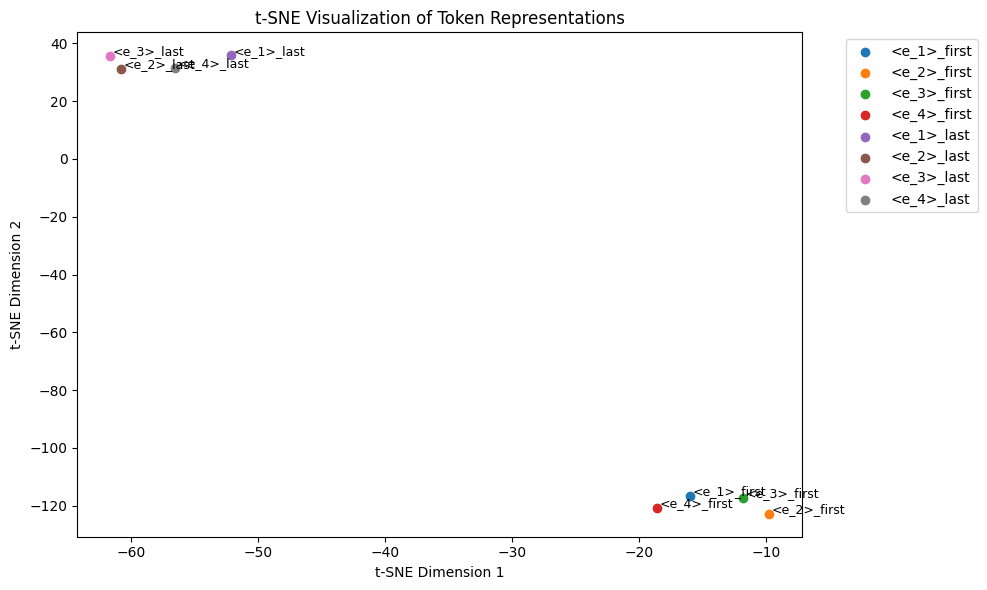

In [55]:


perplexity = 2# min(30, n_samples - 1)  # Set perplexity to a value less than the number of samples
# Perform t-SNE
tsne = TSNE(n_components=2,  perplexity=perplexity,random_state=42)
reduced_embeddings = tsne.fit_transform(all_representations)

# Plot the results
plt.figure(figsize=(10, 6))
for i, label in enumerate(labels):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y, label=label)
    plt.text(x + 0.2, y + 0.2, label, fontsize=9)

plt.title("t-SNE Visualization of Token Representations")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
